In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
import plotly.express as px
from scipy import integrate
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split as ttsplit

Potentiel multimodal

In [3]:

def distance(x0,y0,x,y):
    return np.sqrt((x0-x)*(x0-x)+(y-y0)*(y-y0))

def potV(x0,y0,r,x,y,a):
    dis = distance(x0,y0,x,y)
    print(dis)
    if dis<=r:
        val = -a*(1-abs(x-x0)/r)*(1-abs(x-x0)/r)-a*(1-abs(y-y0)/r)*(1-abs(y-y0)/r)
        return val
    else:
        return 0



N=1000

class MultimodalPotential:
    def __init__(self,bowls_coord, beta):
        """Initialise potential function class

        :param bowls_coord: matrix, where bowls_coord[i]=([x0,y0,r,a])
        where (x0,y0) are the coords of the center of the bowl and r its radius
        a the intensity of the well of potential made by the bowl
        """
        self.beta = beta
        self._bowls_coord=np.copy(bowls_coord)
        print(self._bowls_coord)
        self.dim = 2
        self.nbr_bowls = np.shape(bowls_coord)
        self.Z = None

    def V(self, X):
        """Potential function

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: V: float, potential energy value
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        x = X[0]
        y = X[1]
        V=0
        bowl=self._bowls_coord
        for bowl in self._bowls_coord:
            x0=bowl[0]
            y0=bowl[1]
            r=bowl[2]
            a=bowl[3]
            dis = np.sqrt((x0-x)*(x0-x)+(y-y0)*(y-y0))
            V-=a*np.exp(-dis*dis/(r*r))
        V+=0.2 * (x ** 4) + 0.2 * ((y - 1/3) ** 4)
        return V
    
    def dV_x(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVx: float, derivative of the potential with respect to x
        """
        dVx = 0
        for bowl in self._bowls_coord:
            x0=bowl[0]
            y0=bowl[1]
            r=bowl[2]
            a=bowl[3]
            dis = np.sqrt((x0-x)*(x0-x)+(y-y0)*(y-y0))
            dVx+=2*a*(x-x0)*np.exp(-dis*dis/(r*r))/(r*r)

        dVx+= 0.8 * (x**3)
        return dVx
    
    def dV_y(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVy: float, derivative of the potential with respect to y
        """
        dVy = 0
        for bowl in self._bowls_coord:
            x0=bowl[0]
            y0=bowl[1]
            r=bowl[2]
            a=bowl[3]
            dis = np.sqrt((x0-x)*(x0-x)+(y-y0)*(y-y0))
            dVy+=2*a*(y-y0)*np.exp(-dis*dis/(r*r))/(r*r)

        dVy+= 0.8 * (y-y0)**3
        return dVy
    
    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: grad(X): np.array, gradient with respect to position vector (x,y), ndim = 1, shape = (2,)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        return np.array([self.dV_x(X[0], X[1]), self.dV_y(X[0], X[1])])
        
    def boltz_weight(self, x, y):
        """Compute the unnormalized weight of a configuration according to the Boltzmann distribution

        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: normalized Blotzmann weight
        """
        X = np.array([x, y])
        return np.exp(-self.beta * self.V(X))
    
    def set_Z(self):
        """Partition function to normalize probability densities
        """
        self.Z, _ = integrate.dblquad(self.boltz_weight, -5, 5, -5, 5)  


Potentiel sous-variété

In [4]:
def theta(X):
    x=X[0]
    y=X[1]
    if x>0 and y>=0:
        return np.arctan(y/x)
    if x>0 and y<0:
        return np.arctan(y/x)+2*np.pi
    if x<0:
        return np.arctan(y/x) + np.pi
    if x==0 and y>0:
        return np.pi/2
    else :
        return 3*np.pi/2 
        
class Subvaraitiespotential:
    def __init__(self,A, rs,hs,i,beta):
        """Initialise potential function class

        :param A=Amplitude
        """
        self.Ampl=A
        self.R=rs
        self.length=hs
        self.angle=i
        self.beta = beta


    def V(self, X):
        """Potential function

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: V: float, potential energy value
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        x = X[0]
        y = X[1]
        r=np.sqrt(x**2 + y**2)
        t = theta(X)
        V=self.Ampl*r*np.exp(-r/self.length)*np.cos((np.log(r/self.R)/np.tan(self.angle)-t))
        return V

    def dV_r(self, X):
        """Potential function

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: V: float, derivative of potential energy value in r
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        x = X[0]
        y = X[1]
        r=np.sqrt(x**2 + y**2)
        t = theta(X)
        dV=self.Ampl*np.exp(-r/self.length)*np.cos((np.log(r/self.R)/np.tan(self.angle)-t))*(1-r/self.length)-self.Ampl*np.exp(-r/self.length)*np.sin((np.log(r/self.R)/np.tan(self.angle)-t))/np.tan(self.angle)
        return dV

    def dV_theta(self, X):
        """Potential function

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: V: float, derivative of potential energy value in r
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        x = X[0]
        y = X[1]
        r=np.sqrt(x**2 + y**2)
        t = theta(X)
        dV=self.Ampl*r*np.exp(-r/self.length)*np.sin((np.log(r/self.R)/np.tan(self.angle)-t))
        return dV

    def dV_x(self, x,y):
        X = np.array([x, y])
        r=np.sqrt(x**2 + y**2)
        t = theta(X)
        dVdx= (self.dV_r(X)- self.dV_theta(X)/r)*np.cos(t)
        return dVdx

    def dV_y(self, x,y):
        X = np.array([x, y])
        r=np.sqrt(x**2 + y**2)
        t = theta(X)
        dVdy= (self.dV_r(X) + self.dV_theta(X)/r)*np.sin(t)
        return dVdy

    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: grad(X): np.array, gradient with respect to position vector (x,y), ndim = 1, shape = (2,)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        return np.array([self.dV_x(X[0], X[1]), self.dV_y(X[0], X[1])])
        
    def boltz_weight(self, x, y):
        """Compute the unnormalized weight of a configuration according to the Boltzmann distribution

        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: normalized Blotzmann weight
        """
        X = np.array([x, y])
        return np.exp(-self.beta * self.V(X))
    
    def set_Z(self):
        """Partition function to normalize probability densities
        """
        self.Z, _ = integrate.dblquad(self.boltz_weight, -5, 5, -5, 5)


TriplewellPotential

In [5]:
class TripleWellPotential:
    """Class to gather methods related to the potential function"""
    def __init__(self, beta):
        """Initialise potential function class

        :param beta: float,  inverse temperature = 1 / (k_B * T)
        :param Z: float, partition function (computed below)
        """
        self.beta = beta
        self.dim = 2
        self.Z = None
        
    def V(self, X):
        """Potential fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: V: float, potential energy value
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        x = X[0]
        y = X[1]
        u = g(x) * (g(y - 1/3) - g(y - 5/3))
        v = g(y) * (g(x - 1) + g(x + 1))
        V = 3 * u - 5 * v + 0.2 * (x ** 4) + 0.2 * ((y - 1/3) ** 4)
        return V
    
    def dV_x(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVx: float, derivative of the potential with respect to x
        """
        u = g(x) * (g(y - 1/3) - g(y - 5/3))
        a = g(y) * ((x - 1)*g(x - 1) + (x + 1) * g(x + 1))
        dVx = -6 * x * u + 10 * a + 0.8 * (x ** 3)
        return dVx
    
    def dV_y(self, x, y):
        """
        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: dVy: float, derivative of the potential with respect to y
        """
        u = g(x) * ((y - 1/3) * g(y - 1/3) - (y - 5/3) * g(y - 5/3))
        b = g(y) * (g(x - 1) + g(x + 1))
        dVy = -6 * u + 10 * y * b + 0.8 * ((y - 1/3) ** 3)
        return dVy
    
    def nabla_V(self, X):
        """Gradient of the potential energy fuction

        :param X: np.array, Position  vector (x,y), ndim = 1, shape = (2,)
        :return: grad(X): np.array, gradient with respect to position vector (x,y), ndim = 1, shape = (2,)
        """
        assert(type(X) == np.ndarray)
        assert(X.ndim == 1)
        assert(X.shape[0] == 2)
        return np.array([self.dV_x(X[0], X[1]), self.dV_y(X[0], X[1])])
        
    def boltz_weight(self, x, y):
        """Compute the unnormalized weight of a configuration according to the Boltzmann distribution

        :param x: float, x coordinate
        :param y: float, y coordinate

        :return: normalized Blotzmann weight
        """
        X = np.array([x, y])
        return np.exp(-self.beta * self.V(X))
    
    def set_Z(self):
        """Partition function to normalize probability densities
        """
        self.Z, _ = integrate.dblquad(self.boltz_weight, -5, 5, -5, 5)


Fonctions de visualisation

In [6]:
def create_figure(potential):
    if potential =="multimodal":
        bowls = np.array([[0.5,0.5,0.15,0.2],[0.7,0.87,0.1,1.5],[0.2,0.8,0.1,0.5]])
        Potential = MultimodalPotential(bowls)
        X=np.zeros((N,N))
        Y=np.zeros((N,N))
        Potential_map=np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                X[i,j]=i/N
                Y[i,j]=j/N
                Potential_map[i,j]=Potential.V(np.array([i/N,j/N]))
    else :
        Potential = Subvaraitiespotential(1, 1e-3,2,math.pi/10, 4)
    
        grid = np.linspace(-2,2,100)

        X=np.outer(grid, np.ones(100))
        Y=np.outer(grid + 0.5, np.ones(100)).T
        Potential_map=np.zeros([100, 100])
        for i in range(100):
            for j in range(100):
                    Potential_map[i,j]=Potential.V(np.array([grid[i],grid[j]+0.5]))

    
    fig= plt.figure(figsize=(9,3))
    ax0 = fig.add_subplot(1,2,1, projection='3d')
    ax1 = fig.add_subplot(1,2,2)
    # Plot the surface
    ax0.plot_surface(X, Y, Potential_map, color='b')
    ax1.pcolormesh(X, Y, Potential_map, cmap='coolwarm_r',shading='auto')
    return fig


def create_plots(Potential):

    grid = np.linspace(-2,2,100)
    X = np.outer(grid, np.ones(100))
    Y = np.outer(grid + 0.5, np.ones(100)).T
    potential_on_grid = np.zeros([100, 100])
    for i in range(100):
        for j in range(100):
            potential_on_grid[i, j] = Potential.V(np.array([grid[i], grid[j] + 0.5]))

    fig3D = go.Figure(data=[go.Surface(z=potential_on_grid, x=X, y=Y)])
    fig3D.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
    fig3D.update_layout(title='The potential map', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)       
    )

    return fig3D

We next define a function 'UnbiasedTraj' to generate an trajectory according an Euler--Maruyama discretization 
$$
X^{n+1} = X^n - \Delta t \nabla V(X^n) + \sqrt{\frac{2 \Delta t}{\beta}} \, G^n 
$$
of the overdamped Langevin dynamics
$$
dX_t = -\nabla V(X_t) \, dt + \sqrt{\frac{2}{\beta}} \, dW_t
$$
This functions takes as argument a potential object, initial conditions, the number of simulation steps and a time step. It generates a realization of a trajectory (subsampled at some prescribed rate), and possibly records the value of the potential energy function at the points along the trajectory.

In [7]:
def UnbiasedTraj(pot, X_0, delta_t=1e-3, T=3000, save=1, save_energy=False, seed=0):
    """Simulates an overdamped langevin trajectory with a Euler-Maruyama numerical scheme 

    :param pot: potential object, must have methods for energy gradient and energy evaluation
    :param X_0: Initial position, must be a 2D vector
    :param delta_t: Discretization time step
    :param T: Number of points in the trajectory (the total simulation time is therefore T * delta_t)
    :param save: Integer giving the period (counted in number of steps) at which the trajectory is saved
    :param save_energy: Boolean parameter to save energy along the trajectory

    :return: traj: np.array with ndim = 2 and shape = (T // save + 1, 2)
    :return: Pot_values: np.array with ndim = 2 and shape = (T // save + 1, 1)
    """
    r = np.random.RandomState(seed)
    X = X_0
    dim = X.shape[0]
    traj = [X]
    if save_energy:
        Pot_values = [pot.V(X)]
    else:
        Pot_values = None
    for i in range(T):
        b = r.normal(size=(dim,))
        X = X - pot.nabla_V(X) * delta_t + np.sqrt(2 * delta_t/pot.beta) * b
        if X[0]>2 or X[0]<-2:
            X[0]=2*np.sign(X[0])
        if X[1]>2 or X[1]<-2:
            X[1]=2*np.sign(X[1])
        if i % save==0:
            traj.append(X)
            if save_energy:
                Pot_values.append(pot.V(X))
    return np.array(traj), np.array(Pot_values)

def plot_trajectory(Potential):
    grid = np.linspace(-2,2,100)
    x_plot = np.outer(grid, np.ones(100))
    y_plot = np.outer(grid + 0.5, np.ones(100)).T
    potential_on_grid = np.zeros([100, 100])
    for i in range(100):
        for j in range(100):
            potential_on_grid[i, j] = Potential.V(np.array([grid[i], grid[j] + 0.5]))

    
    delta_t = 0.01
    T = 1000
    x_0 = np.array([-0.177, -0.5753])
    trajectory, _ = UnbiasedTraj(Potential, x_0, delta_t=delta_t, T=T, save=1, save_energy=False, seed=None)
    fig = plt.figure(figsize=(9,3))
    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.pcolormesh(x_plot,y_plot,  potential_on_grid, cmap='coolwarm_r', shading='auto')
    ax0.scatter(trajectory[:,0], trajectory[:,1], marker='x')
    ax1.plot(range(len(trajectory[:,0])), trajectory[:,0], label='x coodinate along trajectory')
    return fig

We now define a model for an autoencoder with PyTorch. You can look up the various functions/classes below in the PyTorch documentation https://pytorch.org/docs/stable/index.html
We consider two models: 
- SimpleAutoEncoder which corresponds to the simplest possible autoencoder going directly from the input to the bottleneck and then to the output
- DeepAutoEncoder which allows to consider more hidden layers

In [9]:

class SimpleAutoEncoder(nn.Module):
    def __init__(self, input_dim,bottleneck_dim):
        """Initialise simplest autoencoder (input->bottleneck->ouput), with hyperbolic tangent activation function
       
        :param input_dim: int, Number of dimension of the input vectors
        :param bottleneck_dim: int, Number of dimension of the bottleneck
        """
        super(SimpleAutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, bottleneck_dim),
            torch.nn.Tanh()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_dim, input_dim),
        )

    def forward(self, inp):
        encoded = self.encoder(inp)
        decoded = self.decoder(encoded)
        return decoded
    
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, bottleneck_dim):
        """Initialise auto encoder with hyperbolic tangent activation function
        You can uncomment certain lines in the encoder and decoder functions to modify the topology of the network
        Make sure when you initialise the AE object that the list 'hidden_dims' has a length consistent with the architecture

        :param input_dim: int, Number of dimension of the input vectors
        :param hidden_dims: list, List of hidden layers
        :param bottleneck_dim: int, Number of dimension of the bottleneck
        """
        super(DeepAutoEncoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dims[0]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[0], hidden_dims[1]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[1], hidden_dims[2]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-1], bottleneck_dim),
            torch.nn.Tanh()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(bottleneck_dim, hidden_dims[-1]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-1], hidden_dims[-2]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[-2], hidden_dims[-3]),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dims[0], input_dim),
        )
    def forward(self, inp):
        # Input Linear function
        encoded = self.encoder(inp)
        decoded = self.decoder(encoded)
        return decoded



We define a function to set the learning parameters for training neural networks: learning rate, loss function, optimizer. 

In [10]:
def set_learning_parameters(model, learning_rate, loss='MSE', optimizer='Adam'):
    """Function to set learning parameter

    :param model: Neural network model build with PyTorch,
    :param learning_rate: Value of the learning rate
    :param loss: String, type of loss desired ('MSE' by default, another choice leads to cross entropy)
    :param optimizer: String, type of optimizer ('Adam' by default, another choice leads to SGD)

    :return:
    """
    #--- chosen loss function ---
    if loss == 'MSE':
        loss_function = nn.MSELoss()
    else:
        loss_function = nn.CrossEntropyLoss()
    #--- chosen optimizer ---
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    return loss_function, optimizer

def train_AE(model, loss_function, optimizer, traj, weights, num_epochs=10, batch_size=32, test_size=0.2):
    """Function to train an AE model

    :param model: Neural network model built with PyTorch,
    :param loss_function: Function built with PyTorch tensors or built-in PyTorch loss function
    :param optimizer: PyTorch optimizer object
    :param traj: np.array, physical trajectory (in the potential pot), ndim == 2, shape == T // save + 1, pot.dim
    :param weights: np.array, weights of each point of the trajectory when the dynamics is biased, ndim == 1, shape == T // save + 1, 1
    :param num_epochs: int, number of times the training goes through the whole dataset
    :param batch_size: int, number of data points per batch for estimation of the gradient
    :param test_size: float, between 0 and 1, giving the proportion of points used to compute test loss

    :return: model, trained neural net model
    :return: training_data, list of lists of train losses and test losses; one per batch per epoch
    """
    #--- prepare the data ---
    # split the dataset into a training set (and its associated weights) and a test set
    X_train, X_test, w_train, w_test = ttsplit(traj, weights, test_size=test_size)
    X_train = torch.tensor(X_train.astype('float32'))
    X_test = torch.tensor(X_test.astype('float32'))
    w_train = torch.tensor(w_train.astype('float32'))
    w_test = torch.tensor(w_test.astype('float32'))
    # intialization of the methods to sample with replacement from the data points (needed since weights are present)
    train_sampler = torch.utils.data.WeightedRandomSampler(w_train, len(w_train))
    test_sampler  = torch.utils.data.WeightedRandomSampler(w_test, len(w_test))
    # method to construct data batches and iterate over them
    train_loader = torch.utils.data.DataLoader(dataset=X_train,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=train_sampler)
    test_loader  = torch.utils.data.DataLoader(dataset=X_test,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               sampler=test_sampler)
    
    #--- start the training over the required number of epochs ---
    training_data = []
    for epoch in range(num_epochs):
        # Train the model by going through the whole dataset
        model.train()
        train_loss = []
        for iteration, X in enumerate(train_loader):
            # Set gradient calculation capabilities
            X.requires_grad_()
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            # Forward pass to get output
            out = model(X)
            # Evaluate loss
            loss = loss_function(out, X)
            # Store loss
            train_loss.append(loss)
            # Get gradient with respect to parameters of the model
            loss.backward()
            # Updating parameters
            optimizer.step()
        # Evaluate the test loss on the test dataset
        model.eval()
        with torch.no_grad():
            test_loss = []
            for iteration, X in enumerate(test_loader):
                out = model(X)
                # Evaluate loss
                loss = loss_function(out, X)
                # Store loss
                test_loss.append(loss)
            training_data.append([torch.tensor(train_loss), torch.tensor(test_loss)])
    return model, training_data


We next define the function to obtain the output of the encoder given the configuration of the system and the one for the gradient of the encoder with respect to the input values. 

In [11]:
def xi_ae(model,  x):
    """Collective variable defined through an auto encoder model

    :param model: Neural network model build with PyTorch
    :param x: np.array, position, ndim = 2, shape = (1,1)

    :return: xi: np.array
    """
    model.eval()
    x = torch.tensor(x.astype('float32'))
    return model.encoder(x).detach().numpy()

def grad_xi_ae(model, x):
    """Gradient of the collective variable defined through an auto encoder model

    :param model: Neural network model build with pytorch,
    :param x: np.array, position, ndim = 2, shape = (1,1)

    :return: grad_xi: np.array
    """
    model.eval()
    x = torch.tensor(x.astype('float32'))
    x.requires_grad_()
    enc = model.encoder(x)
    grad = torch.autograd.grad(enc, x)[0]
    return grad.detach().numpy()

Now we define functions to train our autoencoders and plot the results

In [25]:
def train(ae0, ae1, learning_rate, batch_size, num_epochs, loss, optimizer, trajectory):
    """
        :param potential:  MultimodalPotential, potential
        :param trajectory: np.array

        :return: Fig1: Figure, training and test losses plots
        :return: Fig2: Figure, Collective variables plots
        """
   
    loss_function, optimizer = set_learning_parameters(ae0, learning_rate=learning_rate, loss=loss, optimizer=optimizer)
    ae0, training_data0 = train_AE(ae0,
                                loss_function,
                                optimizer,
                                trajectory,
                                np.ones(trajectory.shape[0]),
                                batch_size=batch_size,
                                num_epochs=num_epochs
                                )
    loss_function, optimizer = set_learning_parameters(ae1, learning_rate=learning_rate, loss=loss, optimizer=optimizer)
    ae1, training_data1 = train_AE(ae1,
                                loss_function,
                                optimizer,
                                trajectory,
                                np.ones(trajectory.shape[0]),
                                batch_size=batch_size,
                                num_epochs=num_epochs
                                )

    #--- plot the evolution of the losses ---
    loss_evol0 = []
    loss_evol1 = []
    # obtain average losses on each epoch by averaging the losses from each batch
    for i in range(len(training_data1)):
        loss_evol0.append([torch.mean(training_data0[i][0]), torch.mean(training_data0[i][1])])
        loss_evol1.append([torch.mean(training_data1[i][0]), torch.mean(training_data1[i][1])])
    loss_evol0 = np.array(loss_evol0)
    loss_evol1 = np.array(loss_evol1)

    # plot these average losses
    fig1, (ax0, ax1)  = plt.subplots(1,2, figsize=(10,4)) 
    ax0.plot(loss_evol0[:, 0], '--', label='train loss', marker='x')
    ax0.plot(range(1, len(loss_evol0[:, 1])), loss_evol0[: -1, 1], '-.', label='test loss', marker='+')
    ax0.legend()
    ax0.set_title("Average losses for the simple AE")
    ax0.set_xlabel('epoch')
    ax0.set_ylabel('loss')
    ax1.plot(loss_evol1[:, 0], '--', label='train loss', marker='x')
    ax1.plot(range(1, len(loss_evol1[:, 1])), loss_evol1[: -1, 1], '-.', label='test loss', marker='+')
    ax1.legend()
    ax1.set_title(" Average losses for the Deep AE")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')

    return fig1
    
def plot_results(ae0, ae1, potential):  
    
    
    #--- plot the contour lines of the AE functions ---
    # construct the grid
    grid = np.linspace(-2,2,100)
    x_plot = np.outer(grid, np.ones(100))
    y_plot = np.outer(grid + 0.5, np.ones(100)).T
    potential_on_grid = np.zeros([100, 100])
    xi_ae0_on_grid = np.zeros([100, 100])
    xi_ae1_on_grid = np.zeros([100, 100])
    #bars= np.zeros(100)
    # compute values of potential and AEs on the grid
    for i in range(100):
        for j in range(100):
            x = np.array([grid[i], grid[j] + 0.5])
            potential_on_grid[i, j] = potential.V(x)
            xi_ae0_on_grid[i,j] = xi_ae(ae0, x)
            xi_ae1_on_grid[i,j] = xi_ae(ae1, x)
    # superimpose contour plots to colormap of the potential
    fig2, (ax0, ax1)  = plt.subplots(1,2, figsize=(9,3))        
    ax0.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
    ax0.contour(x_plot, y_plot, xi_ae0_on_grid, 20, cmap = 'viridis')
    ax0.set_title("Reaction coordinates with the simple AE")
    ax1.pcolormesh(x_plot, y_plot, potential_on_grid, cmap='coolwarm_r',shading='auto')
    ax1.contour(x_plot, y_plot, xi_ae1_on_grid, 20, cmap = 'viridis')
    ax1.set_title("Reaction coordinates with the Deep AE")
    ax0.set_xlabel('x')
    ax0.set_ylabel('y')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    return fig2

def plot_hist(autoencoder, traj):
    """Plot the histogram
    :param autoencoder: model of neural network
                  traj: trajectory with wich we evaluate the encoder array of shape (time, 2)
    :return histogram of the collective variable returned by autoencoder for each position in traj
    """
    cv = []
    #compute cv
    for x in traj:
        cv.append(xi_ae(autoencoder,  x)[0])
        
    #plot_hist
    fig, axis = plt.subplots(figsize =(10, 5))
    axis.hist(cv, edgecolor = 'grey', alpha=0.5, color='blue')
    plt.title('Histogram')
    plt.xlabel('CV obtained by the encoder')
    plt.ylabel('Effective')
    plt.style.use('seaborn-ticks')
    return fig


Let's try to create some potentials and plot the results 

In [36]:
beta=6
bowls = np.array([[-0.7,-0.7,0.5,2],[0.7,0.7,0.5,2], [0,0,0.3,2]])
Potential = MultimodalPotential(bowls,beta)

fig_pot=create_plots(Potential)
fig_pot.show()

[[-0.7 -0.7  0.5  2. ]
 [ 0.7  0.7  0.5  2. ]
 [ 0.   0.   0.3  2. ]]


Let's study some multimodal potentials

Text(0, 0.5, 'y')

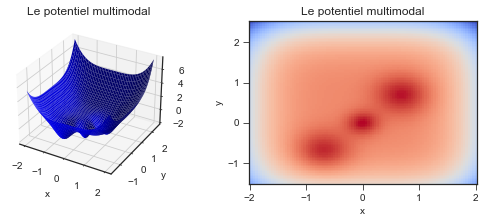

In [37]:

grid = np.linspace(-2,2,100)

X=np.outer(grid, np.ones(100))
Y=np.outer(grid + 0.5, np.ones(100)).T
Potential_map=np.zeros([100, 100])
for i in range(100):
    for j in range(100):
            Potential_map[i,j]=Potential.V(np.array([grid[i],grid[j]+0.5]))

fig= plt.figure(figsize=(9,3))
ax0 = fig.add_subplot(1,2,1, projection='3d')
ax1 = fig.add_subplot(1,2,2)
# Plot the surface
ax0.plot_surface(X, Y, Potential_map, color='b')
ax1.pcolormesh(X, Y, Potential_map, cmap='coolwarm_r',shading='auto')
ax0.set_title('Le potentiel multimodal')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_title('Le potentiel multimodal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

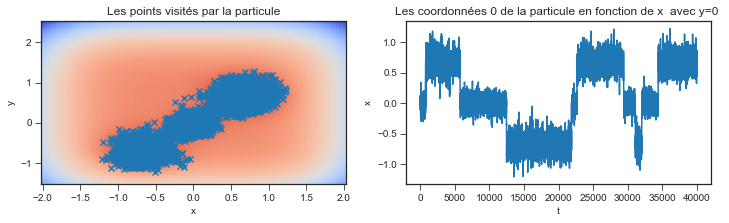

In [38]:
grid = np.linspace(-2,2,100)
x_plot = np.outer(grid, np.ones(100))
y_plot = np.outer(grid + 0.5, np.ones(100)).T
potential_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        potential_on_grid[i, j] = Potential.V(np.array([grid[i], grid[j] + 0.5]))

delta_t = 0.01
T = 40000
x_0 = np.array([0, 0])
#trajectory, _ = pt.UnbiasedTraj(Potential, x_0, delta_t=delta_t, T=T, save=1, save_energy=False, seed=None)
trajectory=np.loadtxt('traj_bowl3bis_1.csv', delimiter=',')
fig = plt.figure(figsize=(12,3))
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)
ax0.pcolormesh(x_plot,y_plot,  potential_on_grid, cmap='coolwarm_r', shading='auto')
ax0.scatter(trajectory[:,0], trajectory[:,1], marker='x')
ax1.plot(range(len(trajectory[:,0])), trajectory[:,0], label='x coodinate along trajectory')
ax0.set_title('Les points visités par la particule')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_title('Les coordonnées 0 de la particule en fonction de x  avec y=0 ')
ax1.set_xlabel('t')
ax1.set_ylabel('x')
#np.savetxt('traj_bowl3_5.csv', trajectory, delimiter = ',')
plt.show()

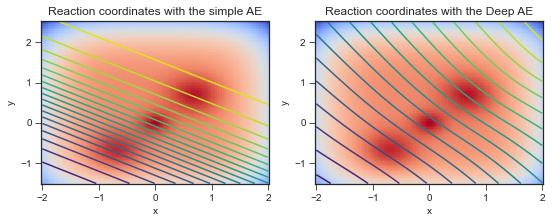

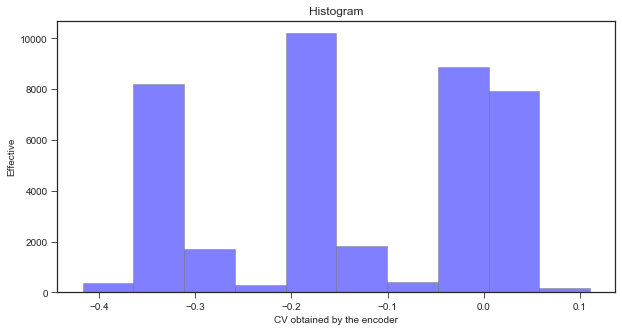

In [39]:
learning_rate = 0.005
batch_size = 100
num_epochs = 500
loss = 'MSE'
optimizer = 'Adam'
ae0 = SimpleAutoEncoder(2,1) 
ae = DeepAutoEncoder(2, [4,8,2], 1)
#fig2=train(ae0, ae, learning_rate, batch_size, num_epochs, loss, optimizer, trajectory)
ae = torch.load('AE_model_mod3_25_02')
fig3=plot_results(ae0, ae,Potential)
#torch.save(ae, 'AE_model_mod3_25_02')
fig4 = plot_hist(ae, trajectory)
plt.show()

Let's study some subvariety potentials

In [31]:

A=1
rs= 1e-2
hs=2
i= math.pi/15
Potential =Subvaraitiespotential(A, rs, hs, i, beta)
fig_pot=create_plots(Potential)
fig_pot.show()

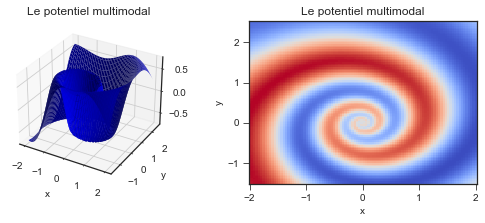

In [32]:
grid = np.linspace(-2,2,100)

X=np.outer(grid, np.ones(100))
Y=np.outer(grid + 0.5, np.ones(100)).T
Potential_map=np.zeros([100, 100])
for i in range(100):
    for j in range(100):
            Potential_map[i,j]=Potential.V(np.array([grid[i],grid[j]+0.5]))

fig= plt.figure(figsize=(9,3))
ax0 = fig.add_subplot(1,2,1, projection='3d')
ax1 = fig.add_subplot(1,2,2)
# Plot the surface
ax0.plot_surface(X, Y, Potential_map, color='b')
ax1.pcolormesh(X, Y, Potential_map, cmap='coolwarm_r',shading='auto')
ax0.set_title('Le potentiel multimodal')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_title('Le potentiel multimodal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.show()

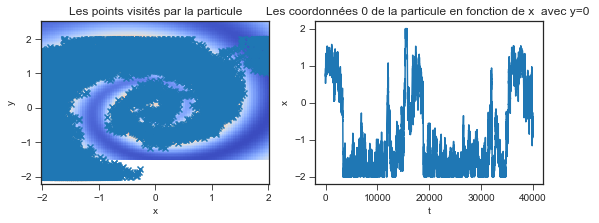

In [34]:

grid = np.linspace(-2,2,100)
x_plot = np.outer(grid, np.ones(100))
y_plot = np.outer(grid + 0.5, np.ones(100)).T
potential_on_grid = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        potential_on_grid[i, j] = Potential.V(np.array([grid[i], grid[j] + 0.5]))



delta_t = 0.01
T = 40000
x_0 = np.array([0.7, 0.7])
#trajectory, _ = pt.UnbiasedTraj(Potential, x_0, delta_t=delta_t, T=T, save=1, save_energy=False, seed=None)
trajectory=np.loadtxt('traj_subbis_1.csv', delimiter=',')
fig0 = plt.figure(figsize=(9,3))
ax0 = fig0.add_subplot(1, 2, 1)
ax1 = fig0.add_subplot(1, 2, 2)
ax0.pcolormesh(x_plot,y_plot,  potential_on_grid, cmap='coolwarm_r', shading='auto')
ax0.scatter(trajectory[:,0], trajectory[:,1], marker='x')
ax1.plot(range(len(trajectory[:,0])), trajectory[:,0], label='x coodinate along trajectory')
ax0.set_title('Les points visités par la particule')
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax1.set_title('Les coordonnées 0 de la particule en fonction de x  avec y=0 ')
ax1.set_xlabel('t')
ax1.set_ylabel('x')
#np.savetxt('traj_subbis_1.csv', trajectory, delimiter = ',')
plt.show()

DeepAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Tanh()
    (6): Linear(in_features=2, out_features=1, bias=True)
    (7): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): Tanh()
    (2): Linear(in_features=2, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Tanh()
    (6): Linear(in_features=4, out_features=2, bias=True)
  )
)


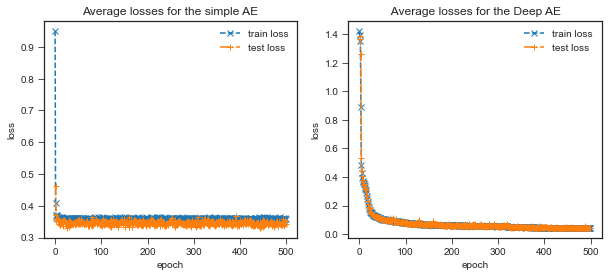

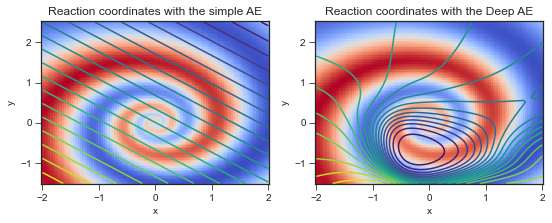

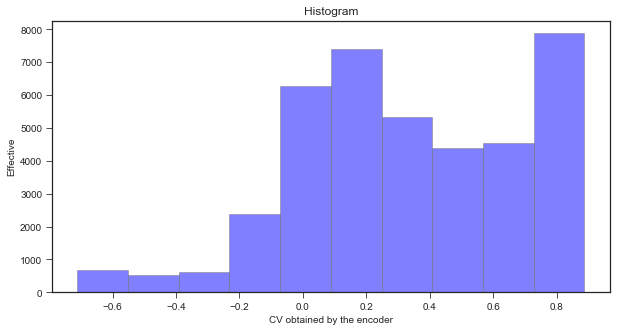

In [35]:
learning_rate = 0.005
batch_size = 100
num_epochs = 500
loss = 'MSE'
optimizer = 'Adam'
ae0 = SimpleAutoEncoder(2,1) 
ae = DeepAutoEncoder(2, [4,8,2], 1)
print(ae)
fig2=train(ae0, ae, learning_rate, batch_size, num_epochs, loss, optimizer, trajectory)
#ae = torch.load('AE_model_sub4')
fig3=plot_results(ae0, ae,Potential)
torch.save(ae, 'AE_model_subbis_25_02')

fig4 = plot_hist(ae, trajectory)

plt.show()